<a href="https://colab.research.google.com/github/AnandKhandekar/Introduction-to-PyMC3/blob/master/Intro_to_PyMC3_03(S%26P500).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
# **Stochastic Volatility**
***

The distribution of **market returns is highly non-normal**, which makes sampling the volatilities significantly more difficult. This example has **400+** parameters so using older sampling algorithms like Metropolis-Hastings would be inefficient, generating highly auto-correlated samples with a low effective sample size. Instead, we use NUTS, which is dramatically more efficient.

## The model

Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which is allowed to change over time.

* $ \sigma∼exp(50)$ 

* $ \nu∼exp(.1)$

* $s_i∼N(s_{i-1},σ^{−2})$

$log(y_i)∼T(ν,0,exp(−2s_ii)).$

Here, $y$ is the response variable, a daily return series which we model with a Student-T distribution having an unknown degrees of freedom parameter, and a scale parameter determined by a latent process $s$. The individual si are the individual daily log volatilities in the latent log volatility process.


In [25]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 8.3MB/s 
     |████████████████████████████████| 4.1MB 46.5MB/s 
     |████████████████████████████████| 327kB 49.8MB/s 
     |████████████████████████████████| 911kB 8.2MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [0]:
import matplotlib.pyplot as plt


In [0]:
import pandas as pd
returns = pd.read_csv('/content/drive/My Drive/SP500.csv',delimiter= ',' ,index_col=0, parse_dates=True)

In [23]:
returns.head()

,S&P500
0,
2008-01-03,0.000000
2008-01-04,-0.024552
2008-01-07,0.003223
2008-01-08,-0.018352
2008-01-09,0.013624


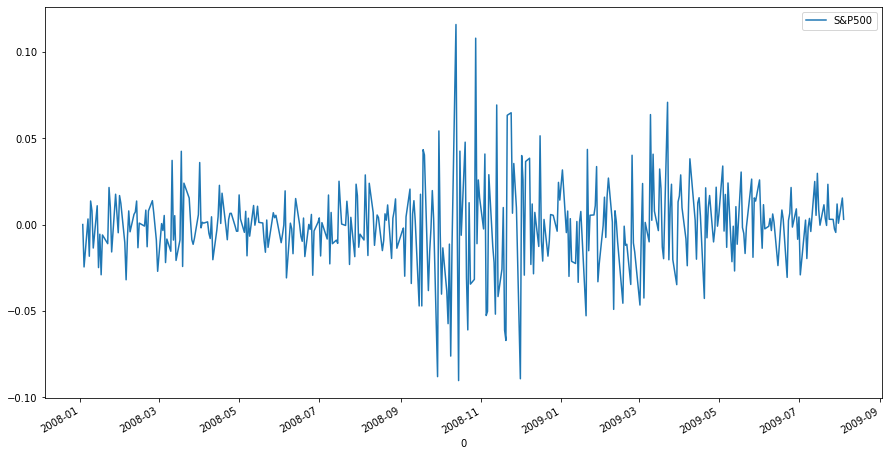

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)

# **Model implementation**

As with the linear regression example, implementing the model in PyMC3 mirrors its **statistical specification**. This model employs several new distributions: the Exponential distribution for the ν and σ priors, the Student-T (StudentT) distribution for distribution of returns, and the GaussianRandomWalk for the prior for the latent volatilities.

In PyMC3, variables with positive support like Exponential are transformed with a log transform, making sampling more robust. Behind the scenes, the variable is transformed to the unconstrained space (named “variableName_log”) and added to the model for sampling. In this model this happens behind the scenes for both the degrees of freedom, $\nu$, and the scale parameter for the volatility process, sigma, since they both have exponential priors. Variables with priors that are constrained on both sides, like Beta or Uniform, are also transformed to be unconstrained, here with a log odds transform.

> Although (unlike model specification in PyMC2) we do not typically provide starting points for variables at the model specification stage, it is possible to provide an initial value for any distribution (called a “test value” in Theano) using the testval argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are invalid and we want to ensure we select a valid one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden.

The vector of latent volatilities $s$ is given a prior distribution by a GaussianRandomWalk object. As its name suggests, GaussianRandomWalk is a vector-valued distribution where the values of the vector form a random normal walk of length n, as specified by the shape argument. The scale of the innovations of the random walk, sigma, is specified in terms of the precision of the normally distributed innovations and can be a scalar or vector.

In [5]:
import pymc3 as pm
from pymc3 import Exponential, StudentT, Exponential, Deterministic
from.pymc3.distributions.timeseries import GaussianRandomWalk

ModuleNotFoundError: ignored

In [0]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=returns['S&P500'])

Notice that we transform the log volatility process s into the volatility process by exp(-2*s). Here, exp is a Theano function, rather than the corresponding function in NumPy; Theano provides a large subset of the mathematical functions that NumPy does.

Also note that we have declared the Model name **sp500_model** in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example. (PyMC@ style of declaring the model name)



***
# **Fitting**
***
Before we draw samples from the posterior, **it is prudent to find a decent starting value, by which we mean a point of relatively high probability**. For this model, the full maximum a posteriori (MAP) point over all variables is degenerate and has infinite density.

But, if we fix log_sigma and nu it is no longer degenerate, so we find the MAP with respect only to the volatility process $s$ keeping log_sigma and $\nu$ constant at their default values (remember that we set testval=.1 for sigma).

> We use the Limited-memory BFGS (L-BFGS) optimizer, which is provided by the scipy.optimize package, as it is more efficient for high dimensional functions; this model includes 400 stochastic random variables.

**As a sampling strategy, we execute a short initial run to locate a volume of high probability, then start again at the new starting point to obtain a sample that can be used for inference. trace[-1] gives us the last point in the sampling trace. NUTS will recalculate the scaling parameters based on the new point, and in this case it leads to faster sampling due to better scaling.**

In [26]:
import scipy
from pymc3 import NUTS, sample

with sp500_model:
    start =  pm.find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)

    step = NUTS(scaling = start)
    trace = sample(100, step, progressbar =False)

    # start te next run at the last sampled position
    step = NUTS( scaling = trace[-1], gamma = .25)
    trace = sample( 2000, step, start = trace[-1], progressbar = True)

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
logp = 1,568.5:   2%|▏         | 87/5000 [00:00<00:04, 991.60it/s] 
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [s, sigma, nu]
The acceptance probability does not match the target. It is 0.8927978996148527, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (2 chains in 1 job)
NUTS: [s, sigma, nu]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [02:10<00:00, 19.10it/s]
The acceptance probability does not match the target. It is 0.6651364086926908, but should be close to 0.8. Try 

We can check our samples by looking at the traceplot for nu and sigma; each parallel chain will be plotted within the same set of axes

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Arg

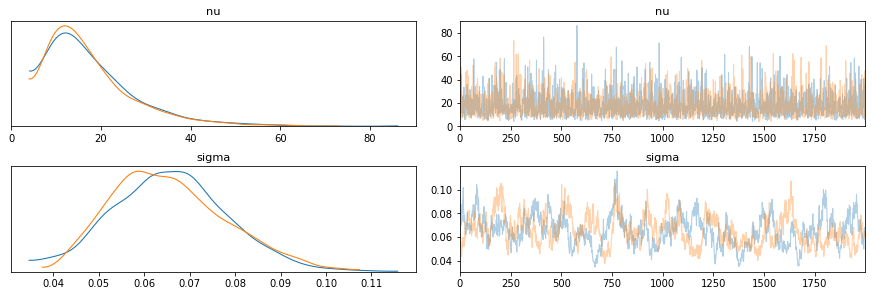

In [27]:
from pymc3 import traceplot
pm.traceplot(trace, varnames=['nu', 'sigma']);

Finally we plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph (Fig. 5). Each is rendered partially transparent (via the alpha argument in Matplotlib’s plot function) so the regions where many paths overlap are shaded more darkly.

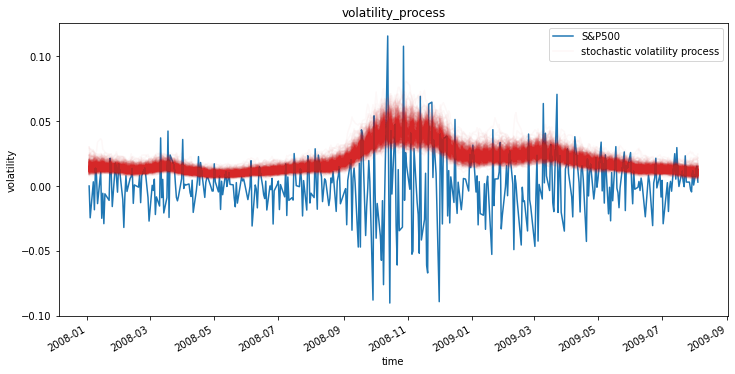

In [28]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 6))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])

As you can see, the model correctly infers the increase in volatility during the 2008 financial crash. Moreover, note that this model is quite complex because of its high dimensionality and dependency-structure in the random walk distribution. NUTS as implemented in PyMC3, however, correctly infers the posterior distribution with ease.